# Лабораторная работа 3

In [530]:
import numpy as np
from math import *
import matplotlib.pyplot as plt
from numpy import linalg as LA
from abc import abstractmethod

# # suppress warnings
# import warnings
# warnings.filterwarnings("ignore")

plt.style.use('dark_background')

In [531]:
class MatrixSolver:
    # compute gradinent of function f in point x with step h
    @staticmethod
    def grad(x, f, eps):
        derivative = np.zeros(np.size(x))
        for i in range(np.size(x)):
            x[i] += eps
            f1 = f(x)
            x[i] -= 2 * eps
            f2 = f(x)
            x[i] += eps
            derivative[i] = (f1 - f2) / (2 * eps)
        return derivative

    # compute Jacobian of functions rs = (r_1...r_n), r_i = r_i(x_1...x_m)
    @staticmethod
    def findJacobian(rs, x, eps):
        n = np.size(rs)
        m = np.size(x)
        J = np.zeros((n, m))
        for i in range(n):
            J[i] = MatrixSolver.grad(x, rs[i], eps)

        return J

    # compute pseudo inverse of matrix X
    @staticmethod
    def pseudoInverse(x):
        return np.linalg.inv(x.T @ x) @ x.T

    # compute hessian of functions R^n -> R
    @staticmethod
    def findHessian(func, x, eps):
        J = MatrixSolver.findJacobian(func, x, eps)
        return 2 * J.T @ J

In [532]:
class Searcher:
    def __init__(self, eps, max_iterations, func, start_x):
        self.eps = eps
        self.max_iterations = max_iterations
        self.func = func
        self.start_x = start_x

    # stop method
    def is_not_final(self):
        return LA.norm(self.next - self.cur_x) > self.eps and self.max_iterations >= self.epoch

    # draw plot
    def draw(self):
        # print("points:", self.points)

        min_point = self.points[-1]
        print("minimum:", min_point)
        
        repoints = np.asarray(self.points).reshape(-1, 2)
        pic = plt.figure(figsize=(10, 10))
        offset = max(np.max(repoints[:, 0]), abs(np.min(repoints[:, 0])))
        xs = np.linspace(min_point[0] - offset, min_point[0] + offset, 1000)

        plt.plot(xs, [self.func([x]) for x in xs])
        plt.plot(repoints[:, 0], repoints[:, 1], 'o-', color="red")
        plt.show()


    def save_point(self, x):
        self.points.append(np.append(x, self.func([x])))

    # executor method
    def run(self, drawing = 1):
        self.epoch = 1
        self.cur_x = self.start_x
        self.points = list()
        self.save_point(self.cur_x)
    
        self.next_point()
        while (self.is_not_final()):
            self.epoch += 1
            self.cur_x = self.next
            self.save_point(self.cur_x)
            self.next_point()

        # предлагаю вместо return поставить draw() типа зачем нам возвращать эти точки дурацикие

        self.save_point(self.next)
        print("argmin: ", self.next, "\nepoches: ", self.epoch)

        if drawing == 1:
            self.draw()


    # find next point
    @abstractmethod
    def next_point(self):
        pass

    


## Gauss-Newton

In [533]:
class GaussNewton(Searcher):

    def calculate(self, r, x):
        n = len(r)
        res = np.zeros(n)
        for i in range(n):
          res[i] = r[i](x)
        return res

    def get_function(self, r):
        return lambda x: self.calculate(r, x)

    def __init__(self, eps, max_iteration, rs, start_x):
        super().__init__(eps, max_iteration, self.get_function(rs), start_x)
        self.rs = rs

    def next_point(self):
        p = MatrixSolver.pseudoInverse(MatrixSolver.findJacobian(self.rs, self.cur_x, self.eps))
        #print(self.cur_x)
        self.next = self.cur_x - p @ self.func(self.cur_x)


## Powell Dog Leg

In [534]:
class Dogleg(Searcher):

    def __init__(self, eps, max_iteration, func, start_x,
                 initial_trust_radius=1.0, max_trust_radius=100.0, eta = 0.15):
        super().__init__(eps, max_iteration, func, start_x)
        self.initial_trust_radius = initial_trust_radius
        self.max_trust_radius = max_trust_radius
        self.eta = eta

    def find_shift(self):
        # find optimum
        optimum = -(np.linalg.inv(self.hess) @ self.jac)
        norm_opt = sqrt(optimum @ optimum)

        if norm_opt <= self.trust_radius:
            return optimum

        # find Cauchy point
        cauchy = - (self.jac @ self.jac / (self.jac @ (self.hess @ self.jac))) @ self.jac
        norm_cauchy = sqrt(cauchy @ cauchy)

        # stop in circul
        if norm_cauchy >= self.trust_radius:
            return self.trust_radius * cauchy / norm_cauchy

        tau = (self.trust_radius - cauchy) / (optimum - cauchy)

        return cauchy + tau * (optimum - cauchy)

    def find_trust_radius(self, shift):
        act_reduction = self.func(self.cur_x) - self.func(self.cur_x + shift)
        pred_reduction = -(self.jac @ shift + 0.5 * (shift @ (self.hess @ shift)))

        rho = act_reduction / pred_reduction
        if pred_reduction == 0.0:
            rho = 1e99

        norm_shift = sqrt(shift @ shift)

        if rho < 0.25:
            self.trust_radius = 0.25 * norm_shift
        else:
            if rho > 0.75 and norm_shift == self.trust_radius:
                self.trust_radius = min(2.0 * self.trust_radius, self.max_trust_radius)
            else:
                self.trust_radius = self.trust_radius


        if rho > self.eta:
            self.next = self.cur_x + shift
        else:
            # too close
            self.next = self.cur_x


    def next_point(self):
        self.jac = MatrixSolver.findJacobian([self.func], self.cur_x, self.eps)
        self.hess = MatrixSolver.findHessian([self.func], self.cur_x, self.eps)
        self.trust_radius = self.initial_trust_radius

        self.find_trust_radius(self.find_shift())


In [535]:
def f1(x):
    return sin(x[0]) + cos(x[0])

def f2(x):
    return 3.2 * sin(x[0]) + 1.7 * x[0] * cos(x[0])

def f3(x):
    return x[0]**4 + 404 * x[0] ** 2 + 123 

### Gauss-Newton tests

Trigonometry:
argmin:  [8.6393798] 
epoches:  6
minimum: [ 8.63937980e+00 -7.77156117e-16]


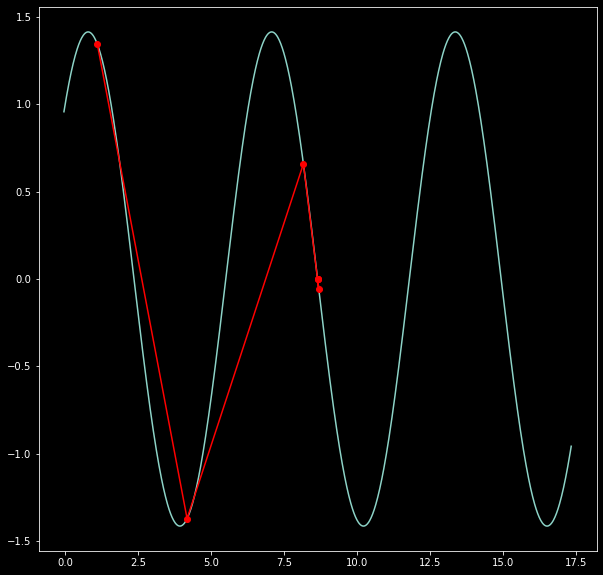

Trigonometry + multiply:
argmin:  [5.06801569] 
epoches:  4
minimum: [5.06801569e+00 1.33226763e-15]


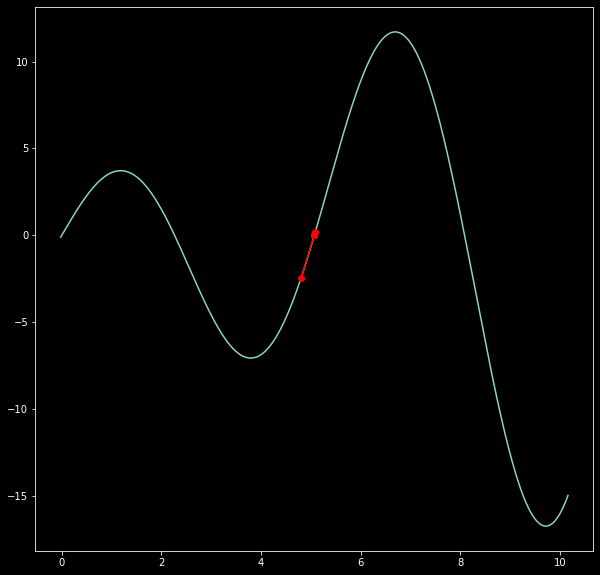

Biquadratic:
argmin:  [2.7631608] 
epoches:  1001
minimum: [2.76316080e+00 3.26585737e+03]


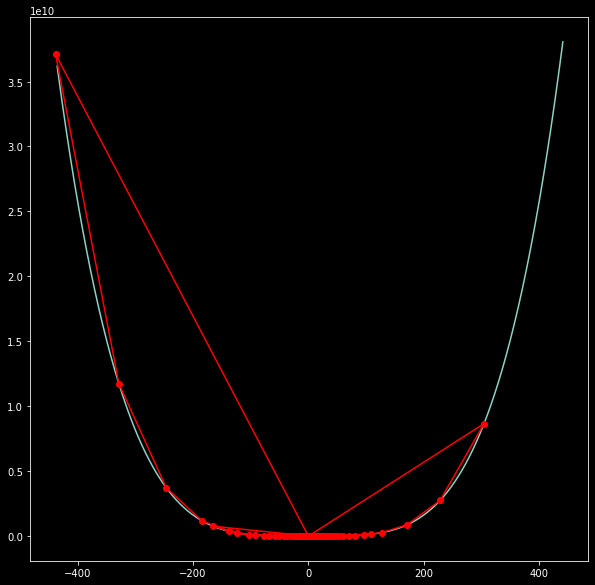

All:
argmin:  [0.09550219] 
epoches:  1001


In [536]:
print("Trigonometry:")
GaussNewton(1e-5, 1000, [f1], np.array([1.1], float)).run()
print("Trigonometry + multiply:")
GaussNewton(1e-5, 1000, [f2], np.array([4.8], float)).run()
print("Biquadratic:")
GaussNewton(1e-5, 1000, [f3], np.array([25.8], float)).run()
print("All:")
GaussNewton(1e-5, 1000, [f1, f2, f3], np.array([30.46], float)).run(0)

### Плохо апроксимирующаяся функция

Sad one:
argmin:  [-1.0001213e+09] 
epoches:  22
minimum: [-1.0001213e+09  0.0000000e+00]


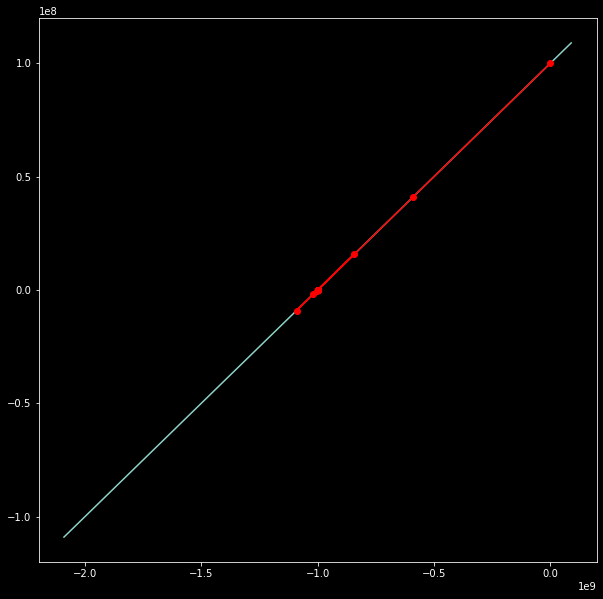

In [537]:
# заблуждается в своих выводах
def shock(x):
    return 0.1*x[0] + 0.07*sin(x[0]) + 100012130

print("Sad one:")
GaussNewton(1e-5, 1000, [shock], np.array([0], float)).run()


### Powell Dog Leg test

Trigonometry:
argmin:  [[3.75891924]] 
epoches:  6
minimum: [ 3.75891924 -1.39428615]


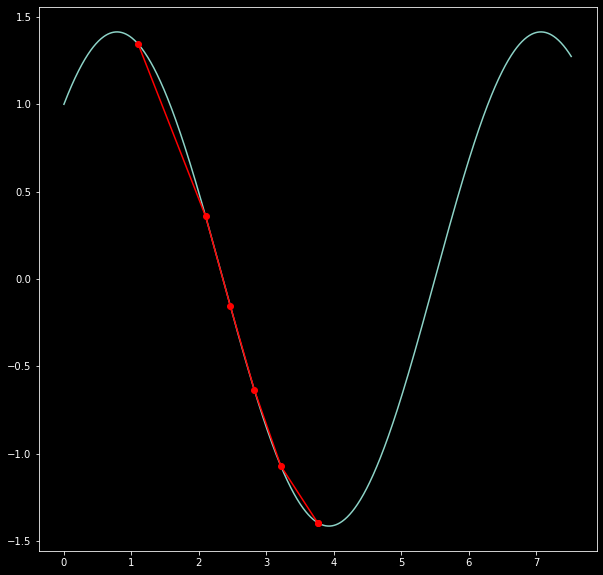

Trigonometry + multiply:
argmin:  [[3.87811227]] 
epoches:  11
minimum: [ 3.87811227 -7.03349485]


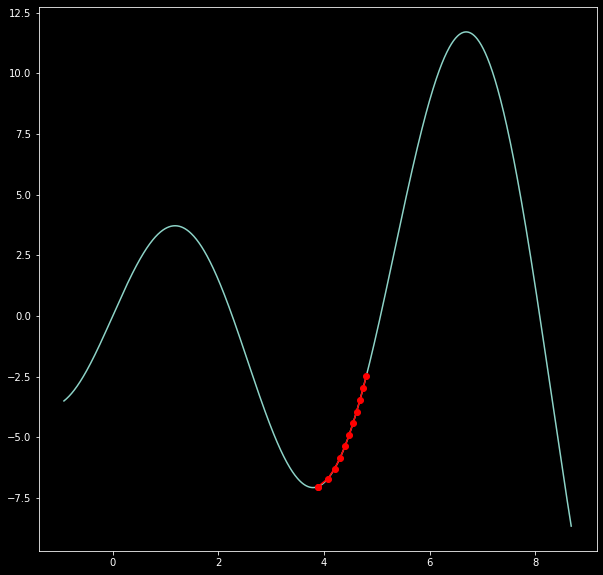

Biquadratic:
argmin:  [[25.79999442]] 
epoches:  1
minimum: [2.57999944e+01 7.12117670e+05]


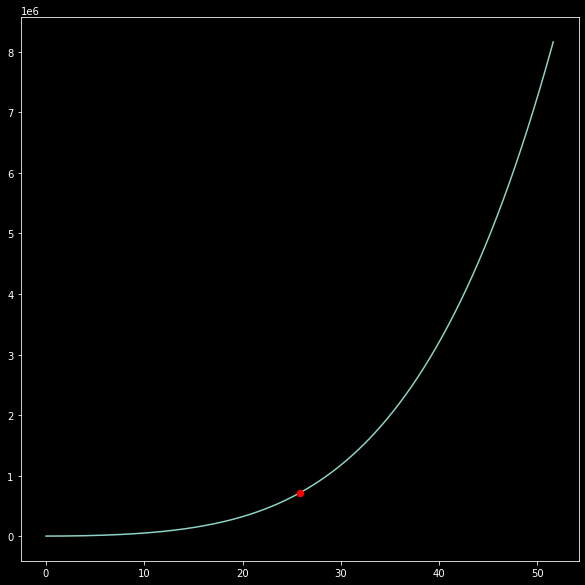

In [538]:
print("Trigonometry:")
Dogleg(1e-5, 1000, f1, np.array([1.1], float)).run()
print("Trigonometry + multiply:")
Dogleg(1e-5, 1000, f2, np.array([4.8], float)).run()
print("Biquadratic:")
Dogleg(1e-5, 1000, f3, np.array([25.8], float)).run()

## BFGS

In [539]:
import numpy as np
from numpy import matmul
import scipy
import scipy.optimize
from math import sin
from math import cos
from functools import partial

class BFGS(Searcher):

    def __init__(self, eps, max_iteration, func, start_x, func_grad):
        super().__init__(eps, max_iteration, func, start_x)
        self.func_grad = func_grad
        self.H = np.eye(len(self.start_x), len(self.start_x))

    def next_H(self, y, s):
        I = np.eye(len(s), len(s)) # единичная матрица
        y_t = np.transpose(y)
        s_t = np.transpose(s)

        g= 1.0/(y_t @ s)
        g_s_y_T=g * (s @ y_t)
        g_y_s_t=g * (y @ s_t)
        return ((I-g_s_y_T) @ (self.H @ (I-g_y_s_t))) + g * (s @ s_t)


    def next_point(self):
        fgrad=MatrixSolver.grad(self.cur_x, self.func, self.eps)
        p = -self.H @ fgrad

        #находим alpha, которая подходит условиям вольфа
        alpha = scipy.optimize.line_search(self.func, self.func_grad , self.cur_x, p, c1=1e-4, c2=0.9) # ищем коэф, удовлетворяющий условию Вольфе
        if alpha[0] is None:
            s = 1e-4 * p
            print("None")
        else:
            s = alpha[0] * p
        
        
        # переход на следующую итерацию
        self.next = self.cur_x + s
        y=MatrixSolver.grad(self.next, self.func, self.eps)-fgrad
        self.H = self.next_H(y, s)


### BFGS tests

In [540]:
def f1_grad(x) :
    return cos(x[0]) - sin(x[0])

def f2_grad(x):
    return 3.2 * cos(x[0]) + 1.7 *(cos(x[0]) - x[0] * sin(x[0]))

def f3_grad(x):
    return 4*x[0]**3 + 800 * x[0] 

Trigonometry:
argmin:  [3.92699082] 
epoches:  3
minimum: [ 3.92699082 -1.41421356]


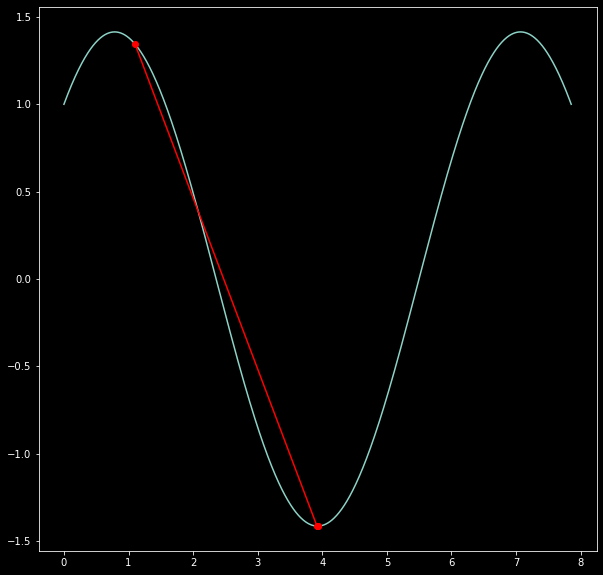

Trigonometry + multiply:
argmin:  [3.79158784] 
epoches:  5
minimum: [ 3.79158784 -7.06791982]


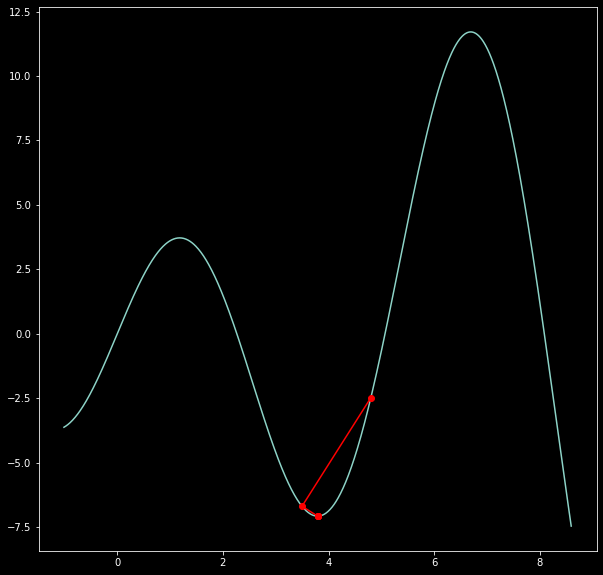

Biquadratic:
argmin:  [-3.10997833e-13] 
epoches:  7
minimum: [-3.10997833e-13  1.23000000e+02]


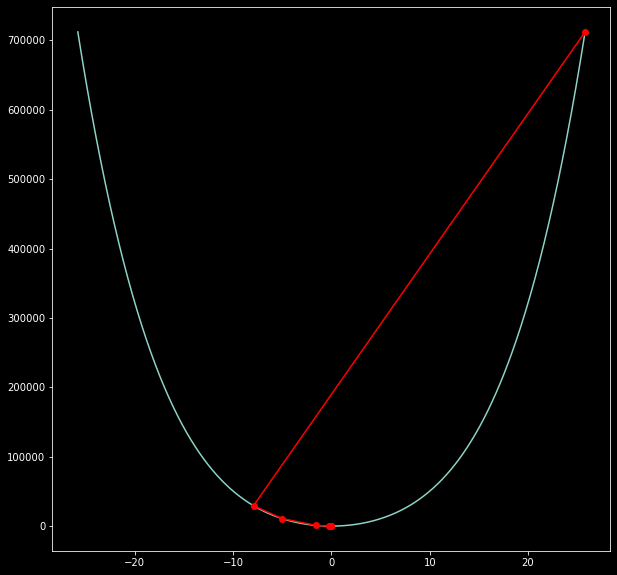

In [541]:
print("Trigonometry:")
BFGS(1e-5, 1000, f1, np.array([1.1], float), f1_grad).run()
print("Trigonometry + multiply:")
BFGS(1e-5, 1000, f2, np.array([4.8], float), f2_grad).run()
print("Biquadratic:")
BFGS(1e-5, 1000, f3, np.array([25.8], float), f3_grad).run()
